# **PINKSHEPZ'S 07 DATA ANALYTIC**
## Dataset
1. *Candlestick price*: XAUUSD TF 1D - 12 Oct 2020 to 8 May 2023
2. *Economic figure report*: FOREX FACTORY TF 1D - 13 Oct 2020 to 31 Dec 2022

## Analytics
1. Candlestick price distribution
    * Line: Time - %Change - Day of the week - Timezone
    * Scatter: %Change of n candlestick - %Change of n+1 candlestick
2. Economic figure distribution
3. Candlestick price x economic figure correlation

## **01 IMPORT & DATA PREPARATION**

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime as dt

# Configure fonts
FONT_PATH = "/workspaces/Enterprise/00_Pinksheepkit/fonts/poppins/Poppins-{0}.ttf"
# FONT_PATH = "c://Users//Art//Documents//A1-AspirePC//CS Project//07_Enterprise//Enterprise//00_Pinksheepkit//fonts//poppins//Poppins-{0}.ttf"
HEADING = "Bold"
LABEL = "Regular"
CONTENT = "Light"

H_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(HEADING)), "size": 12}
L_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(LABEL)), "size": 10}
C_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(CONTENT)), "size": 8}

# Configure plt rc params
# plt.rcParams['figure.dpi'] = 300


In [3]:
# Import dataset
PATH_XAUUSD = '/workspaces/Enterprise/03_Analytics/input/XAUUSD-1H_220103_230503.csv'
PATH_FOREX = '/workspaces/Enterprise/03_Analytics/input/FOREX_311222_131020.csv'

DF_XAUUSD = pd.read_csv(PATH_XAUUSD).iloc[:, 1:]
DF_XAUUSD["time"] = pd.to_datetime(DF_XAUUSD["time"], format='%d-%b-%Y, %H:%M:%S')
for col in DF_XAUUSD.columns[1:]:
    DF_XAUUSD[col] = DF_XAUUSD[col].astype('float64')

DF_FOREX = pd.read_csv(PATH_FOREX).iloc[:, 1:]
DF_FOREX["time"] = pd.to_datetime(DF_XAUUSD["time"], format='%d-%b-%Y, %H:%M:%S')
DF_FOREX['currency'].astype('category')
DF_FOREX['impact'].astype('category')
DF_FOREX['event'].astype('category')

def handle_number_format(number: str) -> list:
    """Return [number as float, unit i.e. % K M]"""
    # Case 1: na
    if number == '':
        return [None, None]
    number = str(number)
    # Case 2: % value
    if (number[-1] == '%') & (number.lstrip('-')[0].isnumeric() == True):
        return [float(number.rstrip('%')), '%']
    # Case 3: 1K 1M 1B 1T unti
    if (number[-1].isalpha() == True) & (number.lstrip('-')[0].isnumeric() == True):
        return [float(str(number)[:-1]), number[-1]]
    # Case 4: ordinary numbers
    if number.replace(',', '').replace('.', '').lstrip('-').isnumeric() == True: 
        return [float(number.replace(',', '')), None]
    # Case 5: non-numbers
    return [number, None]

for col in DF_FOREX.columns[5:]:
    DF_FOREX[col] = DF_FOREX[col].fillna('').apply(handle_number_format)

## **02 CANDLESTICK EDA**

### Line: Time - %Change - Day of the week

In [4]:
WEEK_COLOR = {'MON': 'gold', 'TUE': 'violet', 'WED': 'forestgreen', 'THU': 'orange', 'FRI': 'cornflowerblue', 'SAT': 'mediumpurple'}

DF_XAUUSD_A = DF_XAUUSD.loc[:, ['time', '%Change']]
DF_XAUUSD_A["hour"] = DF_XAUUSD_A["time"].dt.hour
DF_XAUUSD_A["weekday"] = DF_XAUUSD_A["time"].dt.weekday
DF_XAUUSD_A["%Change"] = abs(DF_XAUUSD_A["%Change"])
DF_XAUUSD_A = DF_XAUUSD_A.iloc[:, 1:]
DF_XAUUSD_A = DF_XAUUSD_A.pivot_table(index='hour', columns='weekday', values='%Change', aggfunc='mean')
DF_XAUUSD_A.columns = [*WEEK_COLOR.keys()]

In [5]:
# New York 8am to 5pm EST (1pm to 10pm UTC)
# Tokyo 7pm to 4am EST (12am to 9am UTC)
# Sydney 5pm to 2am EST (10pm to 7am UTC)
# London 3am to 12 noon EST (8am to 5pm UTC)
TZ = {
    'USD': [20, 5],
    'JPY': [7, 16],
    'AUD': [5, 14],
    'GBP': [15, 0]
}

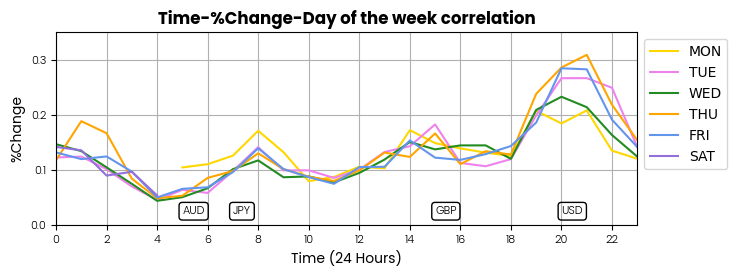

In [6]:
# Plot scatter charts
fig, ax = plt.subplots(1, 1, figsize=(7.5, 2.5))

for column in DF_XAUUSD_A.columns:
    ax.plot(DF_XAUUSD_A.index, 
            DF_XAUUSD_A[column], 
            label=column,
            c=WEEK_COLOR[column])

for tz in TZ:
    ax.text(TZ[tz][0], 0.02, tz, color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), **C_FONT)

# Format charts
ax.legend(bbox_to_anchor=(1, 1))
plt.xticks(**C_FONT)
plt.yticks(**C_FONT)
ax.set_title('Time-%Change-Day of the week correlation', **H_FONT)
ax.set_xlabel('Time (24 Hours)', **L_FONT)
ax.set_xticks(np.arange(0, 24, 2))
ax.set_xlim([0, 23])
ax.set_ylabel('%Change', **L_FONT)
ax.set_ylim([0, 0.35])
ax.grid(True)

### Scatter: %Change of n candlestick - %Change of n+1 candlestick

In [20]:
# DF_XAUUSD_B = pd.concat([round(DF_XAUUSD.loc[0: DF_XAUUSD.shape[0] - 4, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[1: DF_XAUUSD.shape[0] - 3, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[2: DF_XAUUSD.shape[0] - 2, ['%Change']].reset_index(drop=True), 1),
#                          round(DF_XAUUSD.loc[3: DF_XAUUSD.shape[0] - 1, ['%Change']].reset_index(drop=True), 1)],
#                          axis=1)

FRAME = 6
PRECISION = 1

DF_XAUUSD_FRAME = pd.concat([round(DF_XAUUSD.loc[frame: DF_XAUUSD.shape[0] - ((frame * 2) - frame), ['%Change']].reset_index(drop=True), PRECISION)
                         for frame in range(FRAME * 2)],
                         axis=1)

DF_XAUUSD_FRAME.columns = ['i_' + str(frame) for frame in range(FRAME * 2)]

DF_XAUUSD_B = pd.concat([pd.DataFrame({('i_' + str(i + 1) + str(j)): abs(DF_XAUUSD_FRAME.iloc[:, ((i + 1) * j): ((i + 1) * (j + 1))].sum(axis=1))})
                         for (i, j) in zip(sorted([frame for frame in range(FRAME)] * 2), [0, 1] * FRAME)],
                         axis=1)
DF_XAUUSD_B

,i_10,i_11,i_20,i_21,i_30,i_31,i_40,i_41,i_50,i_51,i_60,i_61
0,0.1,0.0,0.1,0.0,0.2,0.2,0.1,0.1,0.0,0.1,0.0,0.0
1,0.0,0.1,0.1,0.2,0.0,0.1,0.1,0.0,0.1,0.2,0.1,0.0
2,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.1,0.0,0.1,0.2
3,0.1,0.1,0.2,0.0,0.2,0.0,0.2,0.2,0.2,0.0,0.2,0.3
4,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.1,0.2,0.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8266,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8267,0.1,0.1,0.0,0.1,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.0
8268,0.1,0.1,0.2,0.0,0.2,0.0,0.2,0.0,0.2,0.0,0.2,0.0
8269,0.1,0.2,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.1,0.0


IndexError: index 2 is out of bounds for axis 0 with size 2

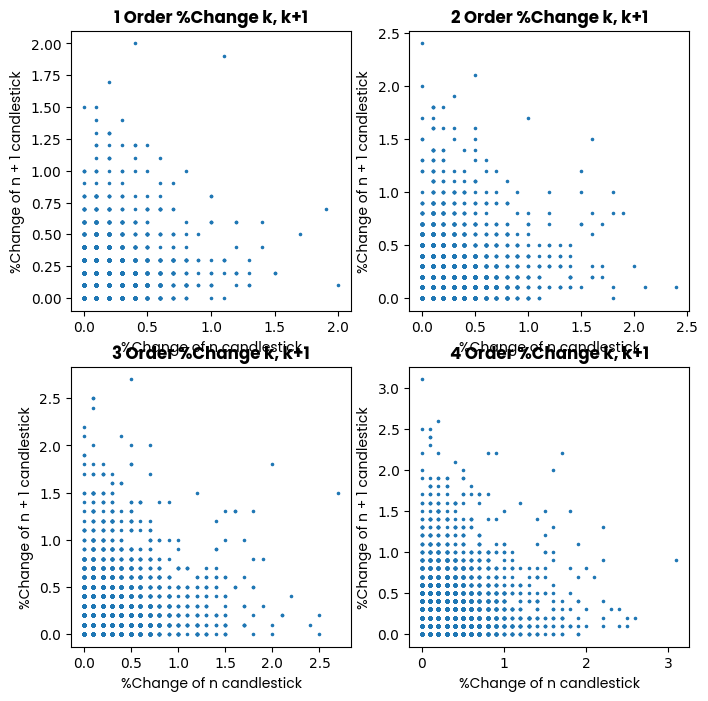

In [38]:
# Plot scatter charts
AX_PER_ROW = 3
FIG_ROW = FRAME // AX_PER_ROW
FIG_COLUMN = FRAME if FRAME < FIG_ROW else FIG_ROW
fig, ax = plt.subplots(FIG_ROW, FIG_COLUMN, figsize=(4 * FIG_COLUMN, 4 * FIG_ROW))

for j in range((FRAME // FIG_ROW)):
    for i in range(FRAME if FRAME < FIG_ROW else FIG_ROW):
        order = (i + 1) + (j * FIG_ROW)
        ax[j][i % FIG_ROW].scatter(DF_XAUUSD_B.iloc[:, (2 * i) + (2 * FIG_ROW * j)], DF_XAUUSD_B.iloc[:, (2 * i) + 1 + (2 * FIG_ROW * j)], s=2.5)
        ax[j][i % FIG_ROW].set_title(str(order) + ' Order %Change k, k+1', **H_FONT)
        ax[j][i % FIG_ROW].set_xlabel('%Change of n candlestick', **L_FONT)
        ax[j][i % FIG_ROW].set_ylabel('%Change of n + 1 candlestick', **L_FONT)
        ax[j][i % FIG_ROW].set_aspect(1)

# Format charts
plt.xticks(**C_FONT)
plt.yticks(**C_FONT)
plt.tight_layout()